### Sand Rate, Mixed Velocity and Erosion calculation from Pysand

__Go through the following steps :__

1. Update TAG, time range, sampling frequency in sec
2. Update R, GF and d_p input
3. Update well input data
4. Update segment name to get correct polynomials for Z.values
5. Update the well name to load correct back ground noise input
6. Update the class variables (D, rho, MW, mu) for the correct well input
7. Select vendor name for the step values
8. Select erosion model and material
<br> Erosion models available : bend, tee, straight_pipe, welded_joint, manifold, reducer, probes, flexible
<br> Materials available : carbon_steel, duplex, ss316, inconel, grp_epoxy, aluminium, dc_05_tungsten, etc

__How the Erosion models selected, and the required input__ :
- bend(v_m, rho_m, mu_m, R, GF, D, d_p, material='duplex', rho_p=2650)
- tee(v_m, rho_m, mu_m, GF, D, d_p, material='duplex', rho_p=2650):
- straight_pipe(v_m, D)
- welded_joint(v_m, rho_m, D, d_p, h, alpha=60, location='downstream', material='duplex')
- manifold(v_m, rho_m, mu_m, GF, D, d_p, Dm, material='duplex')
- reducer(v_m, rho_m, D1, D2, d_p, GF=2, alpha=60, material='duplex')
- probes(v_m, rho_m, D, d_p, alpha=60, material='duplex')
- flexible(v_m, rho_m, mu_m, mbr, D, d_p, material='duplex')
- choke_gallery(v_m, rho_m, mu_m, GF, D, d_p, R_c, gap, H, material='cr_37_tungsten')


For first time user :
1. Install Tagreader :
https://wiki.equinor.com/wiki/index.php/Tagreader-python

2. Install Pysand :
https://github.com/equinor/pysand/blob/master/README.md

***
MMEG

             Row Labels  15/9-A-3 T2
175 2022-01-15 15:30:00         36.8
0.9591850346512896


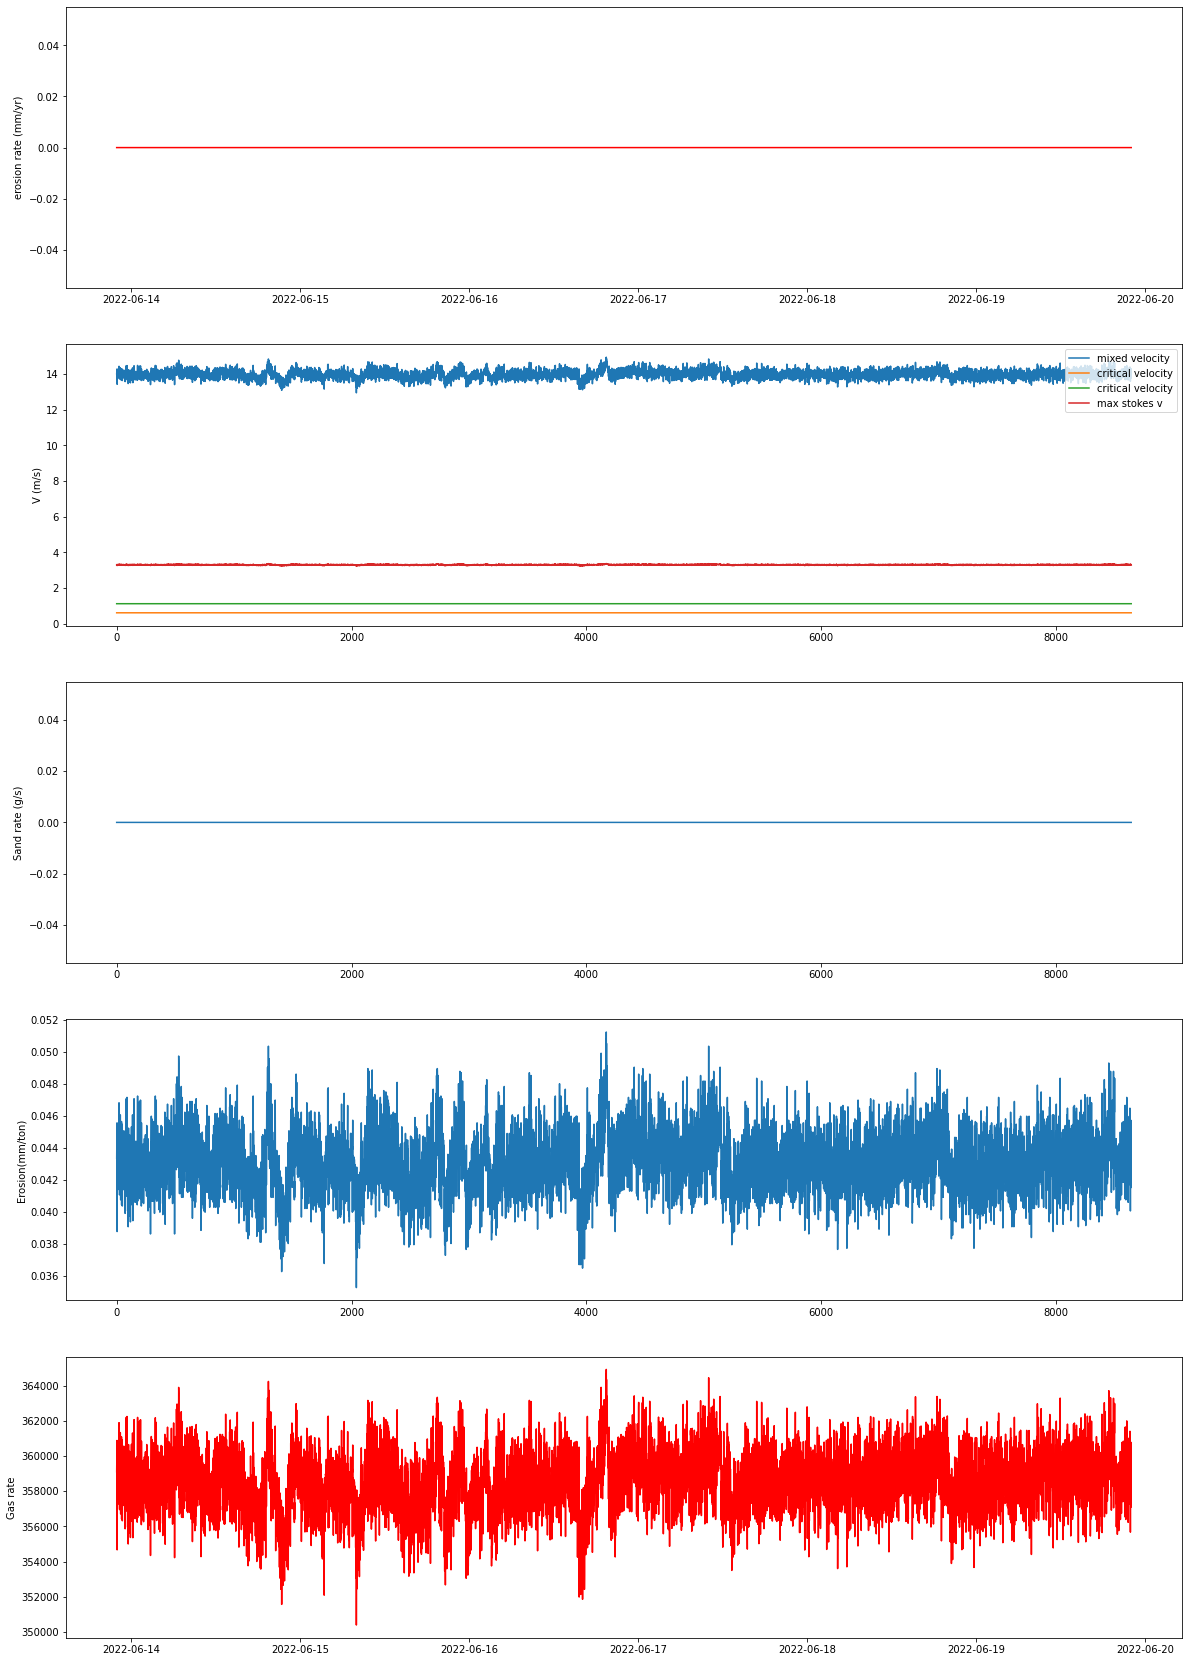

c:\appl\python3_8\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



                          time        WHP           Raw        WHT  Wing  \
0    2022-06-14 00:00:00+02:00  11.927992  16138.474609  61.108017   1.0   
1    2022-06-14 00:01:00+02:00  11.869769  15510.464844  61.203693   1.0   
2    2022-06-14 00:02:00+02:00  12.102803  22197.000000  61.299366   1.0   
3    2022-06-14 00:03:00+02:00  11.772264  18306.513672  61.395039   1.0   
4    2022-06-14 00:04:00+02:00  12.307223  24016.447266  61.383118   1.0   
...                        ...        ...           ...        ...   ...   
8635 2022-06-19 23:55:00+02:00  11.780661  17121.865234  62.273449   1.0   
8636 2022-06-19 23:56:00+02:00  11.914033  19167.478516  62.334118   1.0   
8637 2022-06-19 23:57:00+02:00  11.905575  17101.316406  62.152359   1.0   
8638 2022-06-19 23:58:00+02:00  11.930372  16246.158203  62.135925   1.0   
8639 2022-06-19 23:59:00+02:00  12.100166  18365.425781  62.162403   1.0   

            DSC  E_rate (mm/yr)  E (mm/tonn)  Qs (g/s)  Vmix (m/s)  \
0     11.916969  

In [5]:
import pysand as ps
import numpy as np
import sys
import tagreader
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime, timedelta
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly import tools


#Read data from PI. 
c=tagreader.IMSClient("SLP", "PI")
c.cache = None
c.connect()

#1. Update TAG, time range, sampling frequency in sec
#end = str(datetime.now())
#start = str(datetime.now()- timedelta(days=7))


start = datetime(2022,6,14,0,0,0)
end = datetime(2022,6,19,23,59,0)
#end = start+ timedelta(0,36000)

sampling=60
df1 = c.read(['13-PT___054_','13-AT___274B.Rawdata','13-TT___214_','13-XA___034_','13-PT___234_'], 
             str(start), str(end), sampling)
df1.rename(columns={'13-PT___054_' : 'WHP','13-AT___274B.Rawdata':'Raw','13-TT___214_':'WHT',
                    '13-XA___034_':'Wing','13-PT___234_':'DSC'}, inplace=True)
# time data as column and not only index
df1=df1.reset_index()
n=len(df1['WHP'])


#2. Update R, GF and d_p input

R=1.5 #bend radius, how many times ID's
GF = 4 # geometry factor
d_p = 0.3 # sand size 250 um
deg1=80 # well inclination


##############
#2. Performance curve, write correct well name
df3=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PERF_CURVES.xlsx', 
                  sheet_name='Sheet2',engine='openpyxl')
filter=df3['WELL_NAME'].isin(['A-3'])
df3=df3.loc[filter]


latest=df3['VALID_FROM_DATE'].max()
df3=df3.loc[(df3['VALID_FROM_DATE'] >= latest)]
#df3=df3.loc[(df3['VALID_FROM_DATE'] == '02/01/2022')]

df3=df3.sort_values(["X_VALUE","Y_VALUE"],ascending=True)

WGR=df3['WGR'].max()
CGR=df3['CGR'].max()
Pres_pc= df3['X_VALUE']
Gas_pc= df3['Y_VALUE']


############



#3. Update well input data , sheet name in P
#df3 : perfor curve, df2: Polynomials for Z values, df4:PVT tables, df5:densities, df6: polynomials for background noise
#Only Update the well name in df3 to get correct perf curve input
dfP=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PRESSURES.xlsx', 
                  sheet_name='Sheet1',engine='openpyxl',skiprows=3)
dfZ=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PRESSURES.xlsx', 
                  sheet_name='GUNGNE',engine='openpyxl')


df4=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PVT.xlsx', 
                  sheet_name='PVT',index_col=0,engine='openpyxl')
df5=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PVT.xlsx', 
                  sheet_name='rho',index_col=0,engine='openpyxl')
df6=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PVT.xlsx', 
                  sheet_name='ZERO_SAND',index_col=0,engine='openpyxl')

MW=df5.loc['GUN']['MW_gas']
rho_w=df4.loc['A-3']['Water dens (kg/m3)']
rho_o=df4.loc['A-3']['Oil dens (kg/m3)']
mu_o=df4.loc['A-3']['Oil visc (kg/ms)']
mu_w=df4.loc['A-3']['Water visc (kg/ms)']
mu_g=df4.loc['A-3']['Gas Visc (kg/ms)']


# 4. Use correct well name 
dfP=dfP[['Row Labels','15/9-A-3 T2']]
dfP=dfP[dfP['15/9-A-3 T2'].notna()]

latest=dfP['Row Labels'].max()
dfP=dfP.loc[dfP['Row Labels'] >= latest]

Z=(np.interp(dfP['15/9-A-3 T2'],dfZ['bar'],dfZ['Z'])).mean()

print(dfP)
print(Z)




#5. Update the well name to load correct polynomials for the background noise.
#Polynomials are taken from field watch
zero_pol=df6.loc['A-03b'][2:]


#print(CGR,WGR,zero_pol,pol)

### Define Class for the various calculations. 
#6. Update the class variables (D, rho, MW, mu) for the correct well input

class Calculate:
    D=0.18892 #pipe X-section ID
    
    
       
    def __init__(self, df_pres, df_gas, wgr, cgr, df_whp,df_wht, df_zeropol,df_DSC,df_wing):
        self.df_pres = df_pres
        self.df_gas = df_gas
        self.wgr = wgr
        self.cgr = cgr
        self.df_whp=df_whp
        self.df_wht = df_wht              
        self.df_zeropol = df_zeropol
        self.df_DSC=df_DSC
        self.wing=df_wing
        
        
       
    def qgas(self):
        Qg = np.interp(self.df_whp, self.df_pres, self.df_gas)
        return Qg if self.wing ==1 else 0
            
        
    def qwat(self):
        Qw = self.wgr*np.interp(self.df_whp, self.df_pres, self.df_gas)
        return Qw 
    
    def qoil(self):
        Qo = self.cgr*np.interp(self.df_whp, self.df_pres, self.df_gas)
        return Qo 
    
    def qglr(self):
        glr = self.qgas/(self.qwat+self.qoil)
        return glr  
              
    
    
    def v_m(self):
        v_m = ps.fluidproperties.mix_velocity(self.df_whp, self.df_wht, self.qoil(),self.qwat(), 
                                              self.qgas(),Z,Calculate.D)
        return v_m if v_m >0 else 0.01
  
    
    def zerofunc(self):
        poly_zero = np.poly1d(self.df_zeropol)
        zero= poly_zero(self.v_m())
        #zero=1500
        return zero if self.qgas()>100000 else 70000
        
        
    
    def rho_m(self):
        rho_m = ps.mix_density(self.df_whp, self.df_wht, self.qoil(),self.qwat(),self.qgas(), 
                              rho_o, rho_w, MW,Z)
        return rho_m if rho_m >0 else 0.01
    
    def mu_m(self):
        mu_m = ps.fluidproperties.mix_viscosity(self.df_whp, self.df_wht,self.qoil(),self.qwat() , 
                                               self.qgas(),mu_o, mu_w, mu_g,Z)
        return mu_m if mu_m >0 else 0.01
    
    def rho_l(self):
        rho_l=(rho_w*self.qwat()+rho_o*self.qoil())/(self.qwat()+self.qoil())
        return rho_l if rho_l >0 else 0.01
    
    def mu_l(self):
        mu_l=(mu_w*self.qwat()+mu_o*self.qoil())/(self.qwat()+self.qoil())
        return mu_l if mu_l >0 else 0.01
    
    def v_dsc(self):
        v_dsc = ps.fluidproperties.mix_velocity(self.df_DSC,self.df_wht,self.qoil(),self.qwat(),self.qgas(),Z,Calculate.D)
        return v_dsc if self.wing ==1 else 0
        

### Go through the time WHP data, raw data, and calculate for the erosion
vmix_dsc=[]
step=np.ones([n,1])
E=np.ones([n,1])
E_rate=np.ones([n,1])
Qs=np.ones([n,1])
qgas=[]
zero=[]    
vmix=[]
rho_mix=[]
crit_v=[]
stoke_v1=[]

for i in range(0,n):
    calc = Calculate(Pres_pc,Gas_pc,WGR, CGR,df1['WHP'][i], df1['WHT'][i], zero_pol,df1['DSC'][i],df1['Wing'][i])            
    vmix.append(calc.v_m())
    vmix_dsc.append(calc.v_dsc())  
    zero.append(calc.zerofunc())
    qgas.append(calc.qgas())
    #critical velocity for moving dunes and dispersed flow
    crit_v.append(ps.transport.hydro(Calculate.D,calc.rho_l(),calc.mu_l(),d_p))
    
    #stokes velocity for the actual well inclination
    stoke_v1.append(ps.transport.stokes(calc.rho_m(),calc.mu_m(),d_p,deg1))
    
    #7. Update vendor std_step_clampon, or emerson
    step[i]=ps.asd.std_step_emerson(calc.v_m(),1/CGR)
    Qs[i]=ps.asd.sand_rate(df1['Raw'][i], calc.zerofunc(), step[i])
    rho_mix.append(calc.rho_m())
    #8. Select erosion model and material
    #E is relative erosion in mm/ton
    E[i]=ps.erosion.bend(calc.v_m(), calc.rho_m(), calc.mu_m(), R, GF, Calculate.D, d_p, material='carbon_steel')
    # E_rate is erosion rate in mm/yr
    E_rate[i] =ps.erosion.erosion_rate(E[i],Qs[i][0])

df1['E_rate (mm/yr)']=E_rate
df1['E (mm/tonn)']=E
df1['Qs (g/s)']=Qs
df1['Vmix (m/s)']=vmix
df1['Critical vel (m/s)']=crit_v
df1['Well Name'] = "A-3"
df1['Background Noise'] = zero
df1['Sand lift rate']=stoke_v1
df1['Gas rates (Sm3/d)']=qgas
df1['Mixed density']=rho_mix
df1['Vmix DSC (m/s)']=vmix_dsc

#Plot the results
rcParams['figure.figsize']=20,30
figure,axis=plt.subplots(5)    
#use.values in the date time to avoid pandas converter 
axis[0].plot(df1['time'].values,df1['E_rate (mm/yr)'].values,color='r')
axis[0].set_ylabel('erosion rate (mm/yr)')
axis[1].plot(vmix, label ='mixed velocity')
axis[1].plot(crit_v, label='critical velocity')
axis[1].plot(stoke_v1, label='max stokes v')
axis[1].set_ylabel('velocity (m/s)')
axis[1].legend(loc="upper right")
axis[1].set_ylabel('V (m/s)')
axis[2].plot(Qs)
axis[2].set_ylabel('Sand rate (g/s)')
axis[3].plot(df1['E (mm/tonn)'])
axis[3].set_ylabel('Erosion(mm/ton)')
axis[4].plot(df1['time'].values, qgas, color='r')
axis[4].set_ylabel('Gas rate')

#print(E)
#print(Qs)
#print(crit_v)
plt.show()

df1['SR hourly_avg']=df1['Qs (g/s)'].rolling(window=60).mean()
df1['SR daily_avg']=df1['Qs (g/s)'].rolling(window=1440).mean()

##plotly
trace1=go.Scatter(x=df1['time'],y=zero,
                 mode='lines',name='Zero')

trace2=go.Scatter(x=df1['time'],y=df1['Raw'],
                 mode='lines+markers',name='Raw')


trace3=go.Scatter(x=df1['time'],y=df1['Qs (g/s)'].rolling(window=60).mean(),
                 mode='lines',name='Hourly AVG')

trace4=go.Scatter(x=df1['time'],y=df1['Qs (g/s)'].rolling(window=1440).mean(),
                 mode='lines',name='Daily AVG')

trace5=go.Scatter(x=df1['time'],y=df1['Qs (g/s)'],
                 mode='lines',name='Sand Rates')



fig=tools.make_subplots(rows=2,cols=1,subplot_titles=['ASD','Sand Rates '])
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,1)

fig['layout'].update(title='A-3')

pyo.plot(fig)


#append results to csv file, mode a (append)
#df1.to_csv('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\sand\\A3.csv', mode='a',index=False, header=None)
#df1.to_csv('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\sand\\A3.csv', index=False, header=True)
print(df1)




                    